# Characterize DE mRNAs and lncRNAs gene expression patterns

## <br> 1. Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec

In [2]:
import os

# Directory name
figures_dir = "Figures"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Directory '{figures_dir}' created.")
else:
    print(f"Directory '{figures_dir}' already exists.")


Directory 'Figures' already exists.


## <br> 2. Import Data

In [3]:
Deseq2_Master = pd.read_csv('../04_Deseq2/RDDR_Deseq2_Master_Wald_Bulk_Mouse_with_Mouse_MGI.txt',
                                              delimiter = '\t',
                                              index_col=0)

Deseq2_Master['Dose'] = Deseq2_Master['Dose'].apply(lambda x: '{:.2g}'.format(x)).astype('category')

# Specify the desired order for the Dose levels
dose_order = ['0.03', '0.1', '0.3', '1', '3', '10', '30']

# Convert 'Dose' column to a categorical type with the specified order
Deseq2_Master['Dose'] = pd.Categorical(Deseq2_Master['Dose'], categories=dose_order, ordered=True)

Deseq2_Master

/tmp/local/51388227/ipykernel_2134313/3521033718.py:1: DtypeWarning: Columns (18,22) have mixed types. Specify dtype option on import or set low_memory=False.
  Deseq2_Master = pd.read_csv('../04_Deseq2/RDDR_Deseq2_Master_Wald_Bulk_Mouse_with_Mouse_MGI.txt',


,Gene,MGI_Symbol,Dose,pDRE,AHR,Type,baseMean,Log2FC,Fold-Change,lfcSE,...,padj,chrom,start,end,frame,score,strand,gene_id,transcript_id,NR_annotation
0,lnc100,.,0.03,1,0,lncRNA,0.738981,0.862954,1.818759,2.429333,...,NaN,chr1,21246734,21250265,.,1000,+,lnc_inter_chr1_100,lnc_inter_chr1_100,lnc100
1,lnc1000,Gm32128,0.03,0,8,lncRNA,0.821042,0.929693,1.904871,1.989028,...,NaN,chr1,191152395,191156841,.,1000,+,lnc_inter_chr1_1000,lnc_inter_chr1_1000,lnc1000
2,lnc10003,Gm51875,0.03,0,0,lncRNA,0.300701,0.000000,1.000000,5.656128,...,NaN,chr11,94897782,94903363,.,1000,-,lnc_as_chr11_10003,lnc_as_chr11_10003,lnc10003
3,lnc10003,Gm36385,0.03,0,0,lncRNA,0.300701,0.000000,1.000000,5.656128,...,NaN,chr11,94897782,94903363,.,1000,-,lnc_as_chr11_10003,lnc_as_chr11_10003,lnc10003
4,lnc10004,Dlx4os,0.03,1,0,lncRNA,2.027109,0.000000,1.000000,1.904898,...,1.000000e+00,chr11,95035841,95050060,.,1000,+,lnc_as_chr11_10004,lnc_as_chr11_10004,lnc10004_Dlx4os
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365969,mt-Nd4l,.,30,0,0,mitochondrial protein-coding gene,28.894681,-0.353649,0.782602,0.350916,...,4.619477e-01,chrM,9876,10173,.,.,+,ENSMUSG00000065947,ENSMUSG00000065947,NaN
365970,mt-Nd4,.,30,0,0,mitochondrial protein-coding gene,98368.928940,-0.549831,0.683100,0.082421,...,2.695554e-10,chrM,10166,11544,.,.,+,ENSMUSG00000064363,ENSMUSG00000064363,NaN
365971,mt-Nd5,.,30,0,0,mitochondrial protein-coding gene,67723.157378,-0.101532,0.932043,0.100825,...,4.622247e-01,chrM,11741,13565,.,.,+,ENSMUSG00000064367,ENSMUSG00000064367,NaN
365972,mt-Nd6,.,30,0,0,mitochondrial protein-coding gene,19830.183491,0.154663,1.113162,0.185883,...,5.561182e-01,chrM,13551,14070,.,.,-,ENSMUSG00000064368,ENSMUSG00000064368,NaN


In [4]:
Deseq2_Master['Type'].unique()

array(['lncRNA', 'NM', 'NM#NR', 'NR', 'lincRNA', 'antisense',
       'lncOfInterest', 'mitochondrial protein-coding gene'], dtype=object)

## <br> 3a. Determine DE lncRNAs

In [5]:
Deseq2_Master_lncRNA = Deseq2_Master[(Deseq2_Master['Type']== 'lncRNA') |
                                     (Deseq2_Master['Type']== 'antisense') |
                                     (Deseq2_Master['Type']== 'lincRNA') |
                                     (Deseq2_Master['Type']== 'NR') |
                                     (Deseq2_Master['Type']== 'lncOfInterest')]

Deseq2_Master_lncRNA_DEGs = Deseq2_Master_lncRNA[((Deseq2_Master_lncRNA['Fold-Change'] >= 1.5) | 
                                                 (Deseq2_Master_lncRNA['Fold-Change'] <= 1/1.5)) &
                                                 (Deseq2_Master_lncRNA['padj'] <= 0.05)]

Deseq2_Master_lncRNA_DEGs_with_AHR = Deseq2_Master_lncRNA_DEGs[Deseq2_Master_lncRNA_DEGs['AHR'] >= 1]

Deseq2_Master_lncRNA_DEGs_with_AHR_and_DRE = Deseq2_Master_lncRNA_DEGs_with_AHR[Deseq2_Master_lncRNA_DEGs_with_AHR['pDRE'] >= 1]


# Number of unique 'Gene' values for each DataFrame
num_unique_genes_lncRNA = Deseq2_Master_lncRNA['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_DEGs = Deseq2_Master_lncRNA_DEGs['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_with_AHR = Deseq2_Master_lncRNA_DEGs_with_AHR['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_with_AHR_and_DRE = Deseq2_Master_lncRNA_DEGs_with_AHR_and_DRE['Gene'].drop_duplicates(keep='first').nunique()

# Print the results
print("Total lncRNAs:", num_unique_genes_lncRNA)
print("Total DE lncRNAs:", num_unique_genes_DEGs)
print("Total DE lncRNAs with AHR binding:", num_unique_genes_with_AHR)
print("Total DE lncRNAs with AHR binding and DRE:", num_unique_genes_with_AHR_and_DRE)


Total lncRNAs: 29240
Total DE lncRNAs: 2386
Total DE lncRNAs with AHR binding: 1089
Total DE lncRNAs with AHR binding and DRE: 516


In [6]:
# Number of clusters
num_clusters = 5  # Adjust this number as needed

In [7]:
# Extract unique genes to keep
Genes_to_Keep_List = Deseq2_Master_lncRNA_DEGs[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Deseq2_Master[['Gene', 'Dose', 'Log2FC']].drop_duplicates(keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='Log2FC')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]

selected_df

,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,
lnc27073,-0.643864,-0.080581,-0.355853,-1.373563,-1.419292,-2.129086,-3.325003
lnc13823,-0.387750,-1.120212,-0.928466,-0.617772,-0.802386,-1.873754,-5.724862
lnc45722,-1.512807,-1.423351,-0.324069,-1.130000,-0.809534,-1.537958,-5.685013
lnc43351,-0.096460,-0.215173,-0.264271,-0.235559,-1.214262,-1.850043,-3.636704
lnc13735,-0.015442,0.400143,-0.793335,-0.883126,-0.937642,-1.317003,-5.429346
...,...,...,...,...,...,...,...
lnc14746,-0.049459,-0.591011,-0.031741,-0.197263,0.531533,0.136571,0.656062
Rps15a-ps6,0.117273,0.098025,-0.263841,-0.118811,-0.044033,0.401048,1.140406
lnc14699,0.487059,0.204060,0.287456,0.482589,0.669252,0.951113,1.269099


In [8]:
# Define 6 different colors
colors = ['red','orange', 'green', 'blue', 'purple']
custom_cmap = ListedColormap(colors)

# Define the blue, white, and red colormap
colors = ["#0000FF", "#FFFFFF", "#FF0000"]
blue_white_red = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

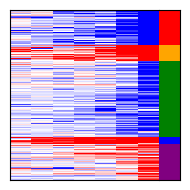

In [9]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/Small_Heatmap_by_Cluster_All_DE_lncRNAs.pdf')

# Show plot
plt.show()



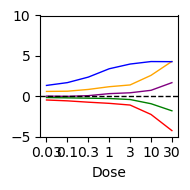

In [10]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.ylim(-5, 10)
plt.yticks([-5,-0,5,10])
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)


# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/Small_RDDR_Cluster_Means_Line_Plot_DE_lncRNAs.pdf')

# Show the plot
plt.show()


## <br> 3b. Determine DE mRNAs

In [11]:
Deseq2_Master_mRNA = Deseq2_Master[(Deseq2_Master['Type'] == 'NM') |
                                    (Deseq2_Master['Type'] == 'NM#NR')|
                                    (Deseq2_Master['Type'] == 'mitochondrial protein-coding gene')]

Deseq2_Master_mRNA_DEGs = Deseq2_Master_mRNA[((Deseq2_Master_mRNA['Fold-Change'] >= 1.5) | 
                                              (Deseq2_Master_mRNA['Fold-Change'] <= 1/1.5)) &
                                              (Deseq2_Master_mRNA['padj'] <= 0.05)]

Deseq2_Master_mRNA_DEGs_with_AHR = Deseq2_Master_mRNA_DEGs[Deseq2_Master_mRNA_DEGs['AHR'] >= 1]

Deseq2_Master_mRNA_DEGs_with_AHR_and_DRE = Deseq2_Master_mRNA_DEGs_with_AHR[Deseq2_Master_mRNA_DEGs_with_AHR['pDRE'] >= 1]

# Number of unique 'Gene' values for each DataFrame
num_unique_genes_mRNA = Deseq2_Master_mRNA['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_DEGs = Deseq2_Master_mRNA_DEGs['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_with_AHR = Deseq2_Master_mRNA_DEGs_with_AHR['Gene'].drop_duplicates(keep='first').nunique()
num_unique_genes_with_AHR_and_DRE = Deseq2_Master_mRNA_DEGs_with_AHR_and_DRE['Gene'].drop_duplicates(keep='first').nunique()

# Print the results
print("Total mRNAs:", num_unique_genes_mRNA)
print("Total DE mRNAs:", num_unique_genes_DEGs)
print("Total DE mRNAs with AHR binding:", num_unique_genes_with_AHR)
print("Total DE mRNAs with AHR binding and DRE:", num_unique_genes_with_AHR_and_DRE)

Total mRNAs: 17179
Total DE mRNAs: 6074
Total DE mRNAs with AHR binding: 3414
Total DE mRNAs with AHR binding and DRE: 2344


In [12]:
# Extract unique genes to keep
Genes_to_Keep_List = Deseq2_Master_mRNA_DEGs[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Deseq2_Master[['Gene', 'Dose', 'Log2FC']].drop_duplicates(keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='Log2FC')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]

selected_df

,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,
Acta1,-9.170372,-9.477045,-26.004716,-25.974980,-8.697238,-2.776175,0.410819
Cabyr,0.152704,0.126729,0.100279,0.078719,-0.232861,-0.428607,-1.457323
Cadm3,-0.147142,-0.070066,-0.338553,-0.193159,-0.279353,0.026091,-0.778994
Camsap3,-0.041097,-0.015517,-0.143331,-0.124021,-0.179731,-0.214386,-0.657533
Camta1,-0.155500,0.061498,-0.170546,-0.068410,-0.157076,-0.446004,-0.868348
...,...,...,...,...,...,...,...
Apol7e,2.391222,-1.622987,1.785265,1.789050,2.639621,2.389472,3.319487
Gsta1,-0.159443,-0.348863,0.720253,1.994231,1.736971,2.538124,4.115881
Csf2rb2,0.423888,0.816555,0.222529,1.318693,2.146425,3.615042,5.323779


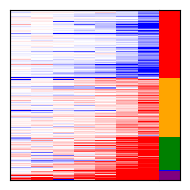

In [13]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/Small_Heatmap_by_Cluster_All_DE_mRNAs.pdf')

# Show plot
plt.show()



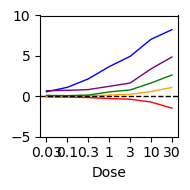

In [14]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.ylim(-5, 10)
plt.yticks([-5,-0,5,10])
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)


# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/Small_RDDR_Cluster_Means_Line_Plot_DE_mRNAs.pdf')

# Show the plot
plt.show()
